In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif

/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
k=5

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData, X_train, X_test, y_train, y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

In [4]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [5]:
# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

In [6]:
# Getting the crash Status
y = leftTurn["crashStatus"]

# Crash and near crash as one field 
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

# Traing test split of the data 
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8, random_state=42)

Number of crashs events:  145.0
Class Balance with Crash and no Crash:  0.506993006993007


# Predicting Crash risk of all the drivers using Support Vector Machine considering crash and near crash as one entry.

In [7]:
# Loading neccesary library for the support vector machine
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

/Users/raviagrawal/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training Accuracy Score:  0.5964912280701754
validation Accuracy Score: 0.5344827586206896
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.56      0.58      0.57        31
      Crash       0.50      0.48      0.49        27

avg / total       0.53      0.53      0.53        58

Confusion matrix, without normalization
[[18 13]
 [14 13]]


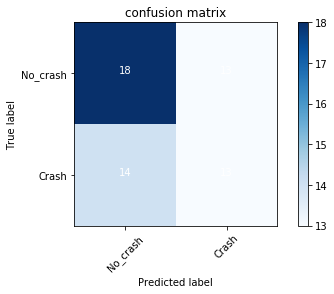

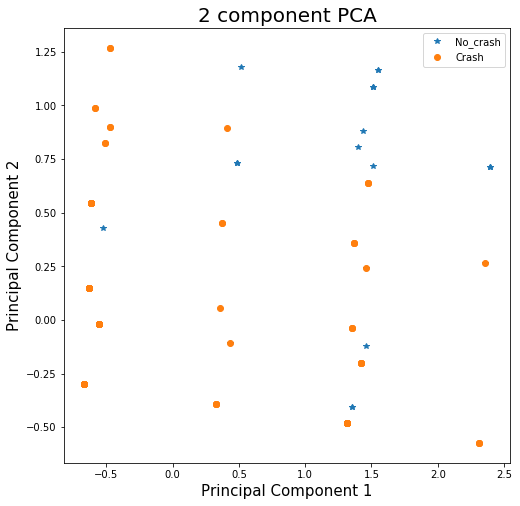

In [8]:
clf = LogisticRegression( penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Support Vector Machine Learning Model to predict crash and no crash risk

Training Accuracy Score:  0.5877192982456141
validation Accuracy Score: 0.5344827586206896
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.56      0.61      0.58        31
      Crash       0.50      0.44      0.47        27

avg / total       0.53      0.53      0.53        58

Confusion matrix, without normalization
[[19 12]
 [15 12]]


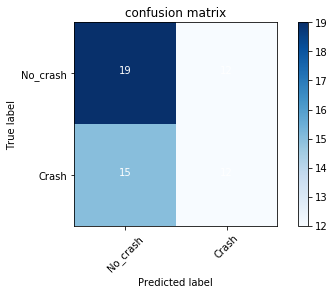

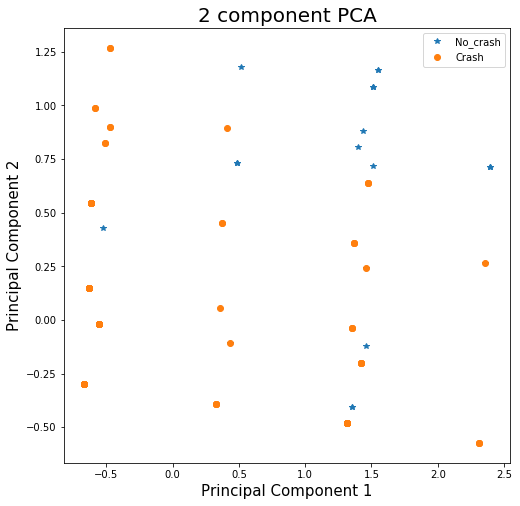

In [9]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [10]:
clf.best_estimator_

SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#  Random Forest Based Machine Learning Models


Training Accuracy Score:  0.6666666666666666
validation Accuracy Score: 0.46551724137931033
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.50      0.55      0.52        31
      Crash       0.42      0.37      0.39        27

avg / total       0.46      0.47      0.46        58

Confusion matrix, without normalization
[[17 14]
 [17 10]]


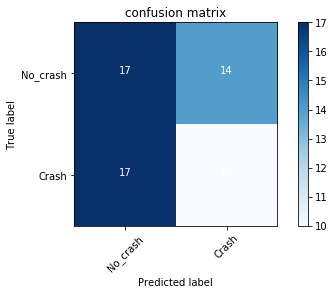

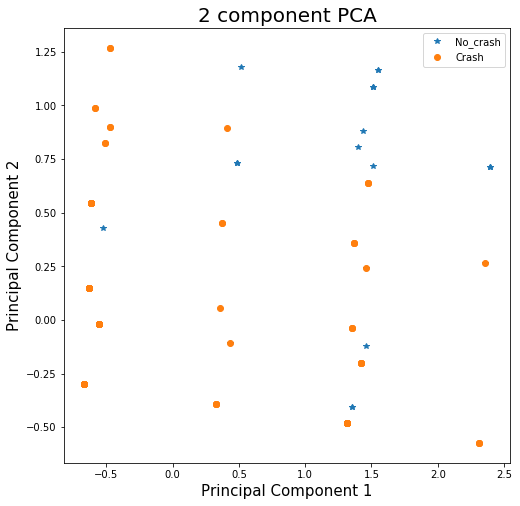

In [11]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [12]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     30.50
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           9.51e-25
Time:                        11:17:12   Log-Likelihood:                -246.69
No. Observations:                 286   AIC:                             503.4
Df Residuals:                     281   BIC:                             521.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hear           0.2456      0.086      2.866      0.0

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

In [13]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)


temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

# Filling Qualtrics Varible with 1


y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)

print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  37.0
Class Balance with Crash and Baseline Condition:  0.20786516853932585


Training Accuracy Score:  0.8064516129032258
validation Accuracy Score: 0.7777777777777778
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.79      0.98      0.88        43
      Crash       0.00      0.00      0.00        11

avg / total       0.63      0.78      0.70        54

Confusion matrix, without normalization
[[42  1]
 [11  0]]


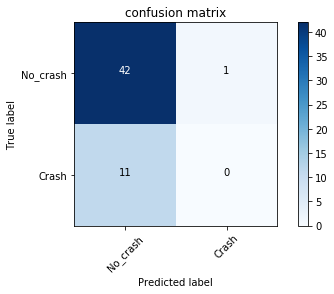

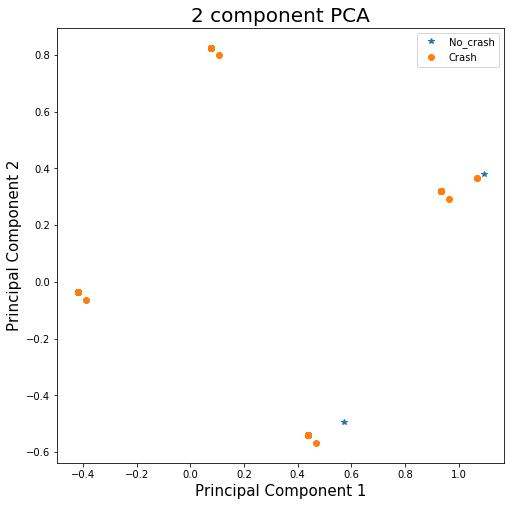

In [14]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.7903225806451613
validation Accuracy Score: 0.7962962962962963
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.80      1.00      0.89        43
      Crash       0.00      0.00      0.00        11

avg / total       0.63      0.80      0.71        54

Confusion matrix, without normalization
[[43  0]
 [11  0]]


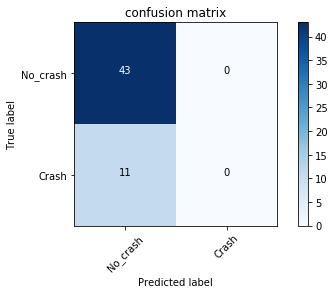

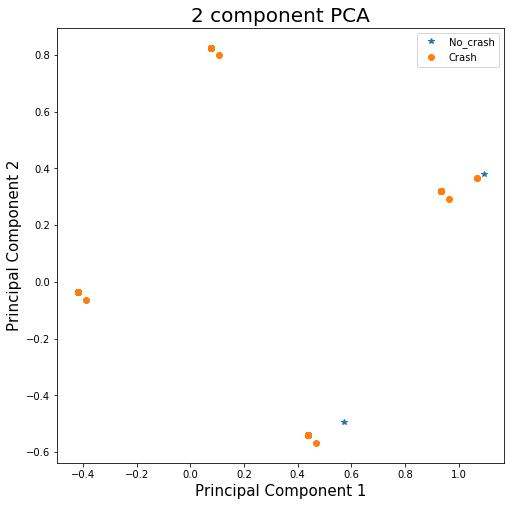

In [15]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.8064516129032258
validation Accuracy Score: 0.7777777777777778
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.79      0.98      0.88        43
      Crash       0.00      0.00      0.00        11

avg / total       0.63      0.78      0.70        54

Confusion matrix, without normalization
[[42  1]
 [11  0]]


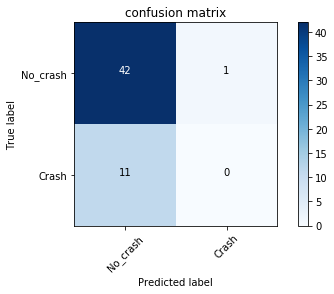

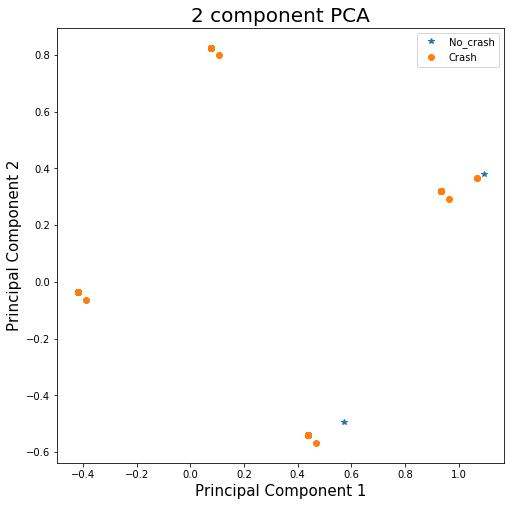

In [16]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [17]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     11.45
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           1.48e-09
Time:                        11:19:18   Log-Likelihood:                -87.327
No. Observations:                 178   AIC:                             184.7
Df Residuals:                     173   BIC:                             200.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
heart          0.1370      0.058      2.346      0.0

# Predicting if the driver is young or old from their driving data all 275 data used


In [18]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus", "age"], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of old drivers:  177.0
Class Balance with old drivers and young driver:  0.6188811188811189


Training Accuracy Score:  0.765
validation Accuracy Score: 0.7093023255813954
Classification Report: 
             precision    recall  f1-score   support

      Young       0.68      0.41      0.51        32
        Old       0.72      0.89      0.79        54

avg / total       0.70      0.71      0.69        86

Confusion matrix, without normalization
[[13 19]
 [ 6 48]]


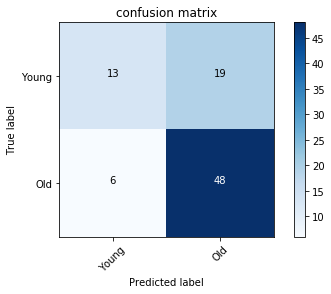

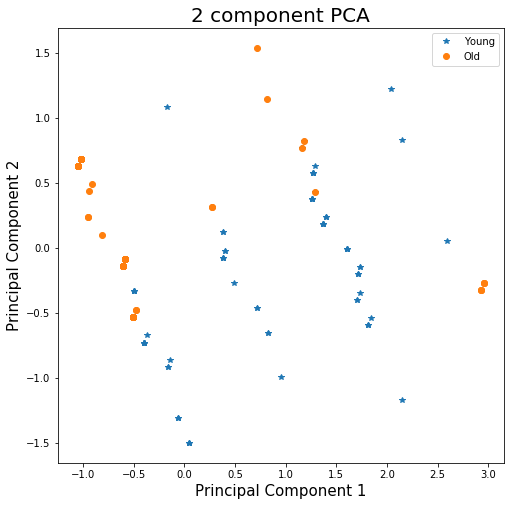

In [19]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
Predicting if the driver is young or old from their driving data all 275 data used¶

Training Accuracy Score:  0.805
validation Accuracy Score: 0.7558139534883721
Classification Report: 
             precision    recall  f1-score   support

      Young       0.76      0.50      0.60        32
        Old       0.75      0.91      0.82        54

avg / total       0.76      0.76      0.74        86

Confusion matrix, without normalization
[[16 16]
 [ 5 49]]


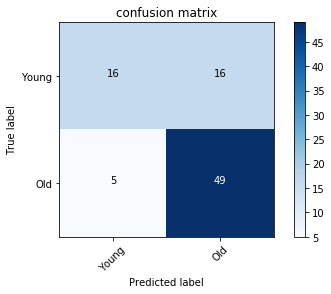

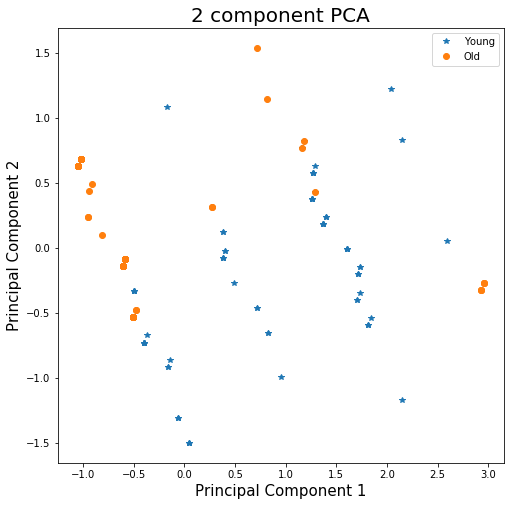

In [20]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.82
validation Accuracy Score: 0.7441860465116279
Classification Report: 
             precision    recall  f1-score   support

      Young       0.73      0.50      0.59        32
        Old       0.75      0.89      0.81        54

avg / total       0.74      0.74      0.73        86

Confusion matrix, without normalization
[[16 16]
 [ 6 48]]


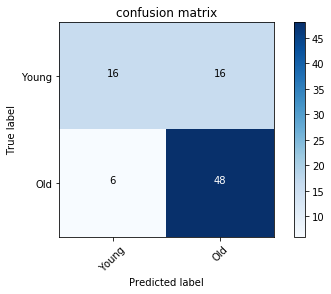

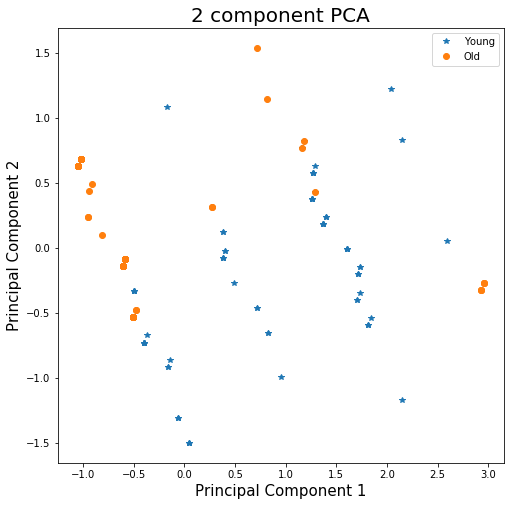

In [21]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [22]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     116.6
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           1.98e-66
Time:                        11:20:00   Log-Likelihood:                -176.54
No. Observations:                 286   AIC:                             363.1
Df Residuals:                     281   BIC:                             381.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hear           0.3113      0.070      4.445      0.0

# Model to predict old driver at risk of crash or not

In [28]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]

temp.fillna(0, inplace = True)

temp = temp.replace("(null)", 0)

data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 



y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  25.0
Class Balance with Crash and Baseline Condition:  0.45454545454545453


Training Accuracy Score:  0.7105263157894737
validation Accuracy Score: 0.7058823529411765
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.70      0.78      0.74         9
   Old drivers at risk       0.71      0.62      0.67         8

           avg / total       0.71      0.71      0.70        17

Confusion matrix, without normalization
[[7 2]
 [3 5]]


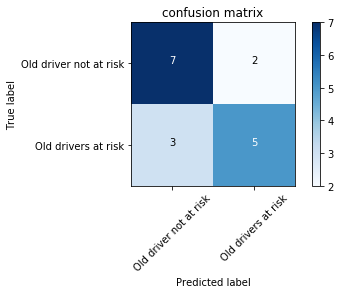

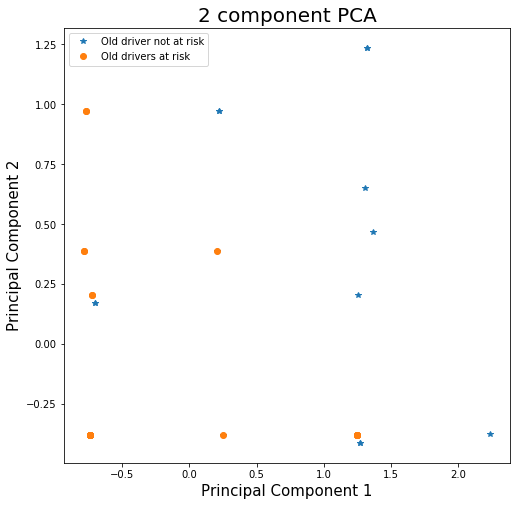

In [29]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict old driver at risk of crash or not:

Training Accuracy Score:  0.7105263157894737
validation Accuracy Score: 0.7647058823529411
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.69      1.00      0.82         9
   Old drivers at risk       1.00      0.50      0.67         8

           avg / total       0.84      0.76      0.75        17

Confusion matrix, without normalization
[[9 0]
 [4 4]]


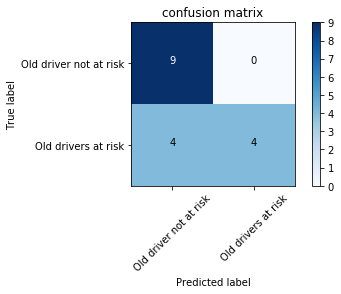

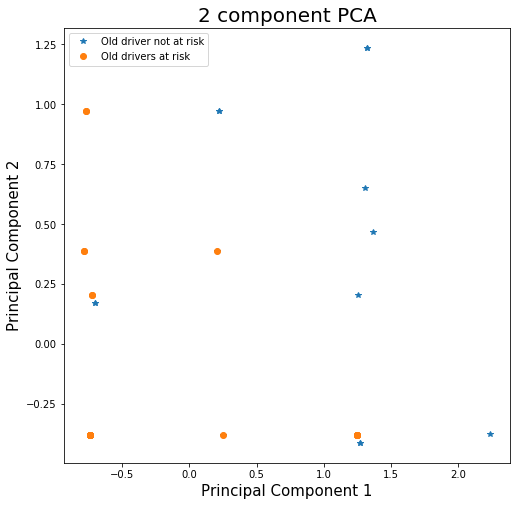

In [25]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    predict old driver at risk of crash or not:


Training Accuracy Score:  0.7631578947368421
validation Accuracy Score: 0.7647058823529411
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.73      0.89      0.80         9
   Old drivers at risk       0.83      0.62      0.71         8

           avg / total       0.78      0.76      0.76        17

Confusion matrix, without normalization
[[8 1]
 [3 5]]


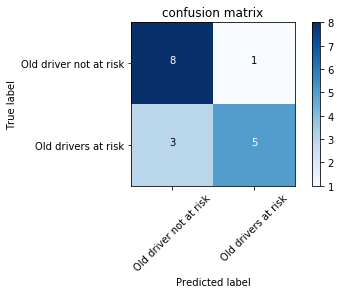

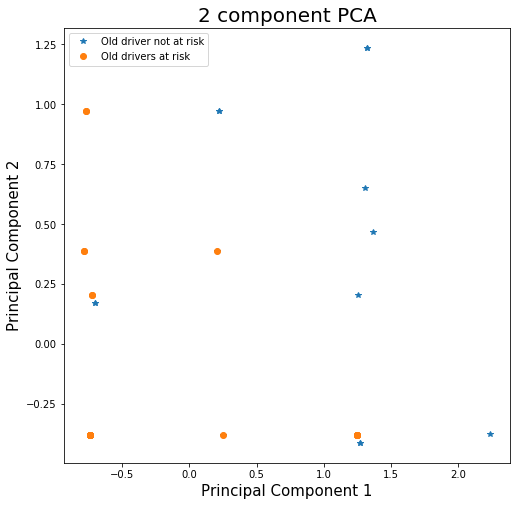

In [26]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [27]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     16.97
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           8.79e-10
Time:                        11:20:37   Log-Likelihood:                -29.070
No. Observations:                  55   AIC:                             68.14
Df Residuals:                      50   BIC:                             78.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hear           0.1858      0.146      1.274      0.2

# drivers 65 or less at the crash risk or not

In [30]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']]

temp.fillna(0, inplace = True)

temp = temp.replace("(null)", 0)

data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] = temp

filledData = data[['hear', 'heart', 'resp',
       'brain', 'vasc', 'nrvsandSlp', 'metab', 'limFlex', 'sevArthr', 'psych',
       'multMedConds', 'multMeds', 'dhiVisual', 'dhiFOV', 'clockDrawaing']] 

# Filling Qualtrics Varible with 1
y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.3333333333333333


Training Accuracy Score:  0.6190476190476191
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


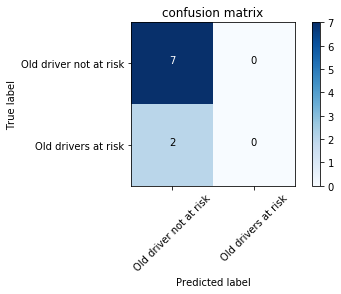

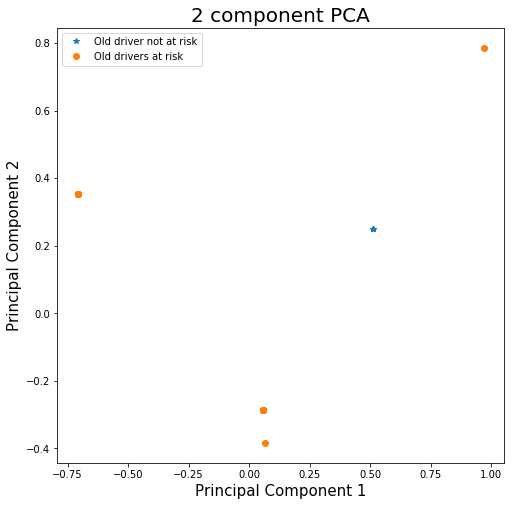

In [31]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict drivers 65 or less at the crash risk or not¶


Training Accuracy Score:  0.8571428571428571
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


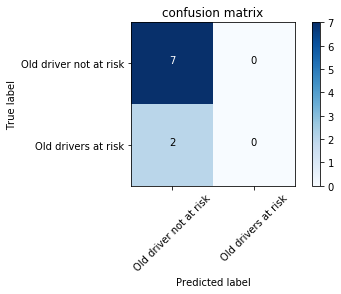

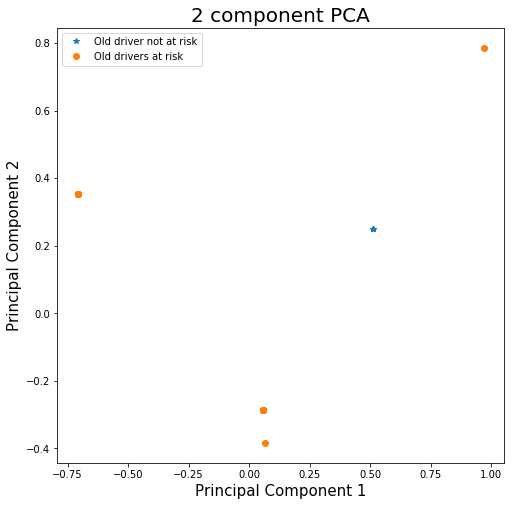

In [32]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
drivers 65 or less at the crash risk or not¶¶

Training Accuracy Score:  0.8571428571428571
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


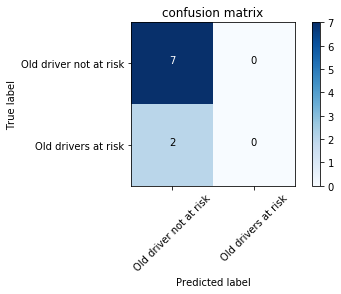

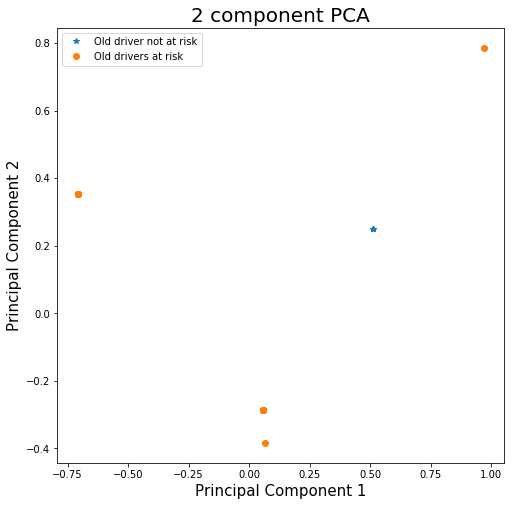

In [33]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [34]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     3.537
Date:                Wed, 24 Oct 2018   Prob (F-statistic):             0.0149
Time:                        11:21:36   Log-Likelihood:                -18.065
No. Observations:                  30   AIC:                             46.13
Df Residuals:                      25   BIC:                             53.14
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hear                0      0.484          0      1.0